# Cell Segmentation in Phase-Contrast Microscopy Using Deep Learning
---

## Import required libraries

Installed the required libraries: opencv-python and pycocotools.
Imported essential libraries for computer vision and COCO dataset handling.

In [2]:
#Import libraries
import os
import json
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
!pip install pycocotools
from pycocotools.coco import COCO

## Preprocess Images and Annotations

Defined the annotation file path (LIVECell_train.json) and validated its existence.
Specified the image folder path for phase-contrast images and confirmed its correctness.
Both checks (assert statements) are well-placed to ensure the paths are valid before further processing.

### Load the Annotations and Filter Matched Images

In [4]:
# Define the annotation file path
annotation_file = r"C:\Users\shali\Documents\L&D\GitHub Projects\Machine Learning\003_LIVECell_Segmentation of Cells_U-Net\annotations\LIVECell_train.json"

# Verify the file exists
import os
assert os.path.exists(annotation_file), "Annotation file not found!"
print("Annotation file path is correct.")

Annotation file path is correct.


In [6]:
# Define path to the images folder containing images for model training and validation
image_folder = r"C:\Users\shali\Documents\L&D\GitHub Projects\Machine Learning\003_LIVECell_Segmentation of Cells_U-Net\images\train_val set"

# Verify that the folder exists
import os
assert os.path.exists(image_folder), "Image folder not found!"
print("Image folder path is correct.")

Image folder path is correct.


**Summary**

**Annotation File Path**
- The file path for the COCO annotation file is correctly defined.
- The `os.path.exists()` function ensures the file exists before proceeding.

**Image Folder Path**
- The phase-contrast image folder path is also verified.

**Assertions**
- The use of `assert` is a good practice to ensure the code stops early if files or folders are missing.


In [8]:
# Load COCO annotations
from pycocotools.coco import COCO

# Initialise COCO
coco = COCO(annotation_file)

# List all image files in the images folder
image_files = os.listdir(image_folder)
image_files = [f for f in image_files if f.endswith('.tif')]  # Filter TIFF files

print(f"Total images in phase_contrast folder: {len(image_files)}")

# Map image file names to COCO IDs
image_filename_to_id = {}
for img in coco.dataset['images']:
    if img['file_name'] in image_files:
        image_filename_to_id[img['file_name']] = img['id']

print(f"Total images matched with annotations: {len(image_filename_to_id)}")

loading annotations into memory...
Done (t=17.28s)
creating index...
index created!
Total images in phase_contrast folder: 679
Total images matched with annotations: 572


**Summary**

**COCO Annotation Loading**
- The COCO annotation file is successfully loaded, with annotations indexed and ready for use.

**Image File Filtering**
- A total of 679 `.tif` files are identified in the phase-contrast image folder.

**Mapping Filenames to COCO IDs**
- Image filenames are mapped to their corresponding COCO IDs to ensure only annotated images are paired.
- This step results in 572 matched images.

**Output Verification**
- The difference between total images (679) and matched images (572) is expected, as not all images have annotations.
- The process effectively prepares the dataset for further analysis.

### Display an Image with Annotations

- Pick an image from the matched set.
- Load its corresponding segmentation masks.
- Display the image and overlay the masks.

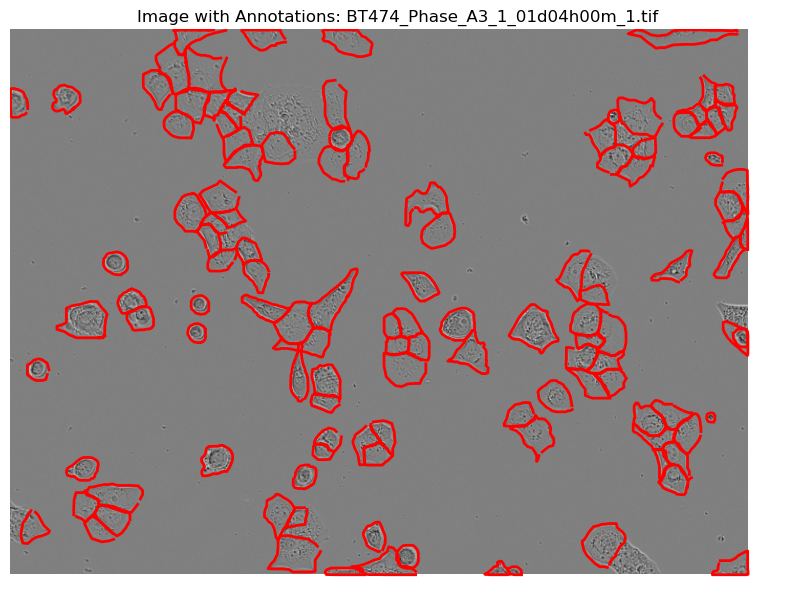

In [10]:
# Pick the first matched image
image_file = list(image_filename_to_id.keys())[0]
image_id = image_filename_to_id[image_file]

# Load the image
image_path = os.path.join(image_folder, image_file)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get annotations for the image
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)

# Display the origial image with file name
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(f"Image with Annotations: {image_file}")

# Overlay cell boundaries on the image
for ann in annotations:
    for seg in ann['segmentation']:
        poly = np.array(seg).reshape((len(seg) // 2, 2))
        plt.plot(poly[:, 0], poly[:, 1], color='red', linewidth=2)

plt.axis('off')
plt.show()

Loaded and displayed the image:
Successfully loaded the first image using OpenCV and displayed it using Matplotlib.
Retrieved relevant annotations:
Extracted annotations for the selected image using the COCO API.
Overlayed segmentation masks:
Plotted the segmentation masks over the image using the red outline. This is visually clear and precise.
The segmentation masks align well with the cell boundaries, showing that your annotations and processing pipeline are working correctly.

## Generate Ground Truth Masks

To prepare the dataset for model training, we need to:

- Resize images and masks to a consistent size (e.g., 512x512). Ensures all images and masks are the same size.
- Normalise images (scale pixel values between 0 and 1).
- Create ground truth masks from the annotations. Converts the segmentation annotations into a binary image where:
    - Pixel value 1 represents the cells (foreground).
    - Pixel value 0 represents the background.


In [12]:
# Preprocessing: Resize images and create grouth truth masks
def preprocess_image_and_mask(image_path, annotations, img_size=(512, 512)):
    """
    Resize the image and create a grouth truth mask with proper alignment.
    """
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Original dimensions
    original_height, original_width = image.shape[:2]
    
    # Resize the image
    image_resized = cv2.resize(image, img_size) / 255.0  # Normalise to [0, 1]

    # Create an empty binary mask
    mask = np.zeros(img_size, dtype=np.uint8)

    # Overlay segmentation masks
    for ann in annotations:
        for seg in ann['segmentation']:
            # Rescale coordinates
            poly = np.array(seg).reshape((len(seg) // 2, 2)).astype(np.float32)
            scale_x = img_size[0] / original_width
            scale_y = img_size[1] / original_height

            # Apply consistent scaling
            poly[:, 0] *= scale_x
            poly[:, 1] *= scale_y

            # Round coordinates AFTER scaling
            poly = np.round(poly).astype(np.int32)

            # Fill the binary mask
            cv2.fillPoly(mask, [poly], 1)

    return image_resized, mask

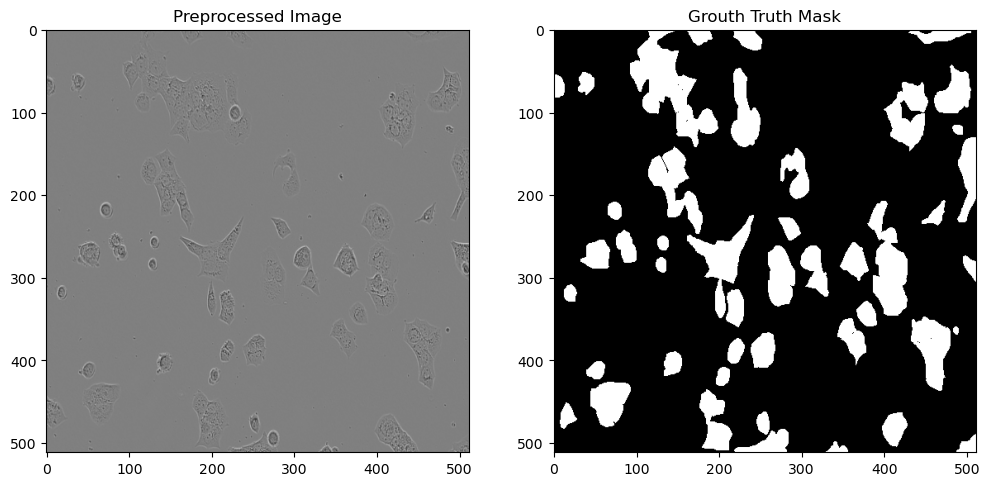

In [14]:
# Test preprocessing on one image
image, mask = preprocess_image_and_mask(image_path, annotations)

# Visualise preprocessed image and mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Grouth Truth Mask")
plt.imshow(mask, cmap='gray')

plt.show()

### Tightening the Mask (Better Edge Definition)

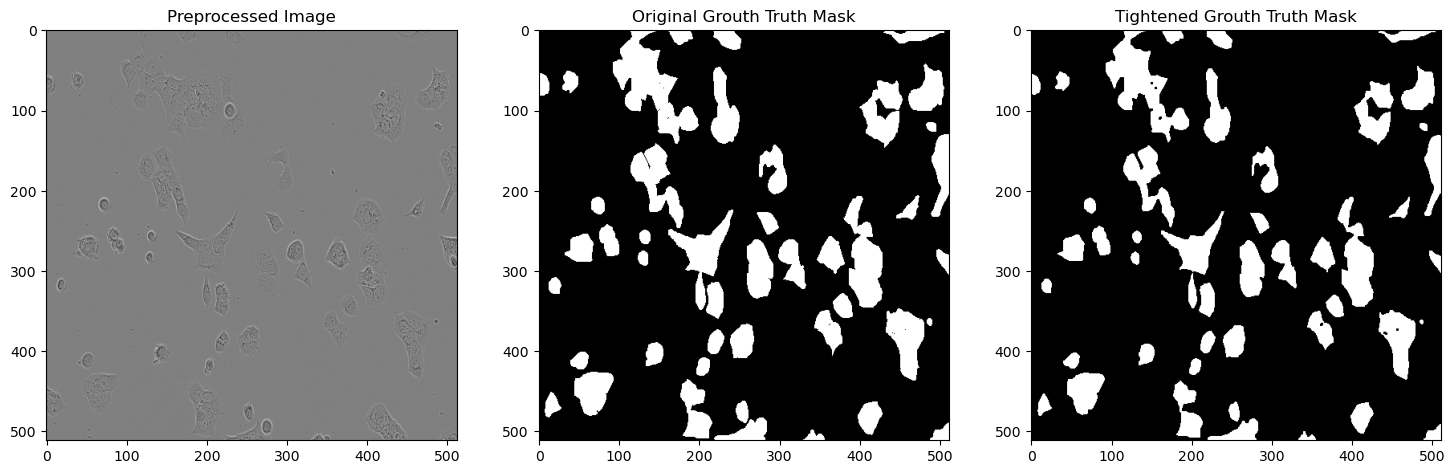

In [16]:
# Tighten mask using morphological erosion
kernel = np.ones((3, 3), np.uint8)  # Define a small 3x3 kernel
mask_tightened = cv2.erode(mask, kernel, iterations=1)  # Apply erosion to tighten mask

# Optional: Smooth edges slightly using Gaussian Blur and re-binarise
mask_smoothed = cv2.GaussianBlur(mask_tightened.astype(np.float32), (3, 3), 0)
mask_final = (mask_smoothed > 0.5).astype(np.uint8)  # Threshold to binarise

# Visualise original vs tightened mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Preprocessed Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Original Grouth Truth Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Tightened Grouth Truth Mask")
plt.imshow(mask_final, cmap='gray')

plt.show()

Morphological operations + smoothing = improved mask quality.
Better masks improve the performance of U-Net as they provide cleaner ground truth data for training.

## Try watershed algorithm to explore instance segmentation

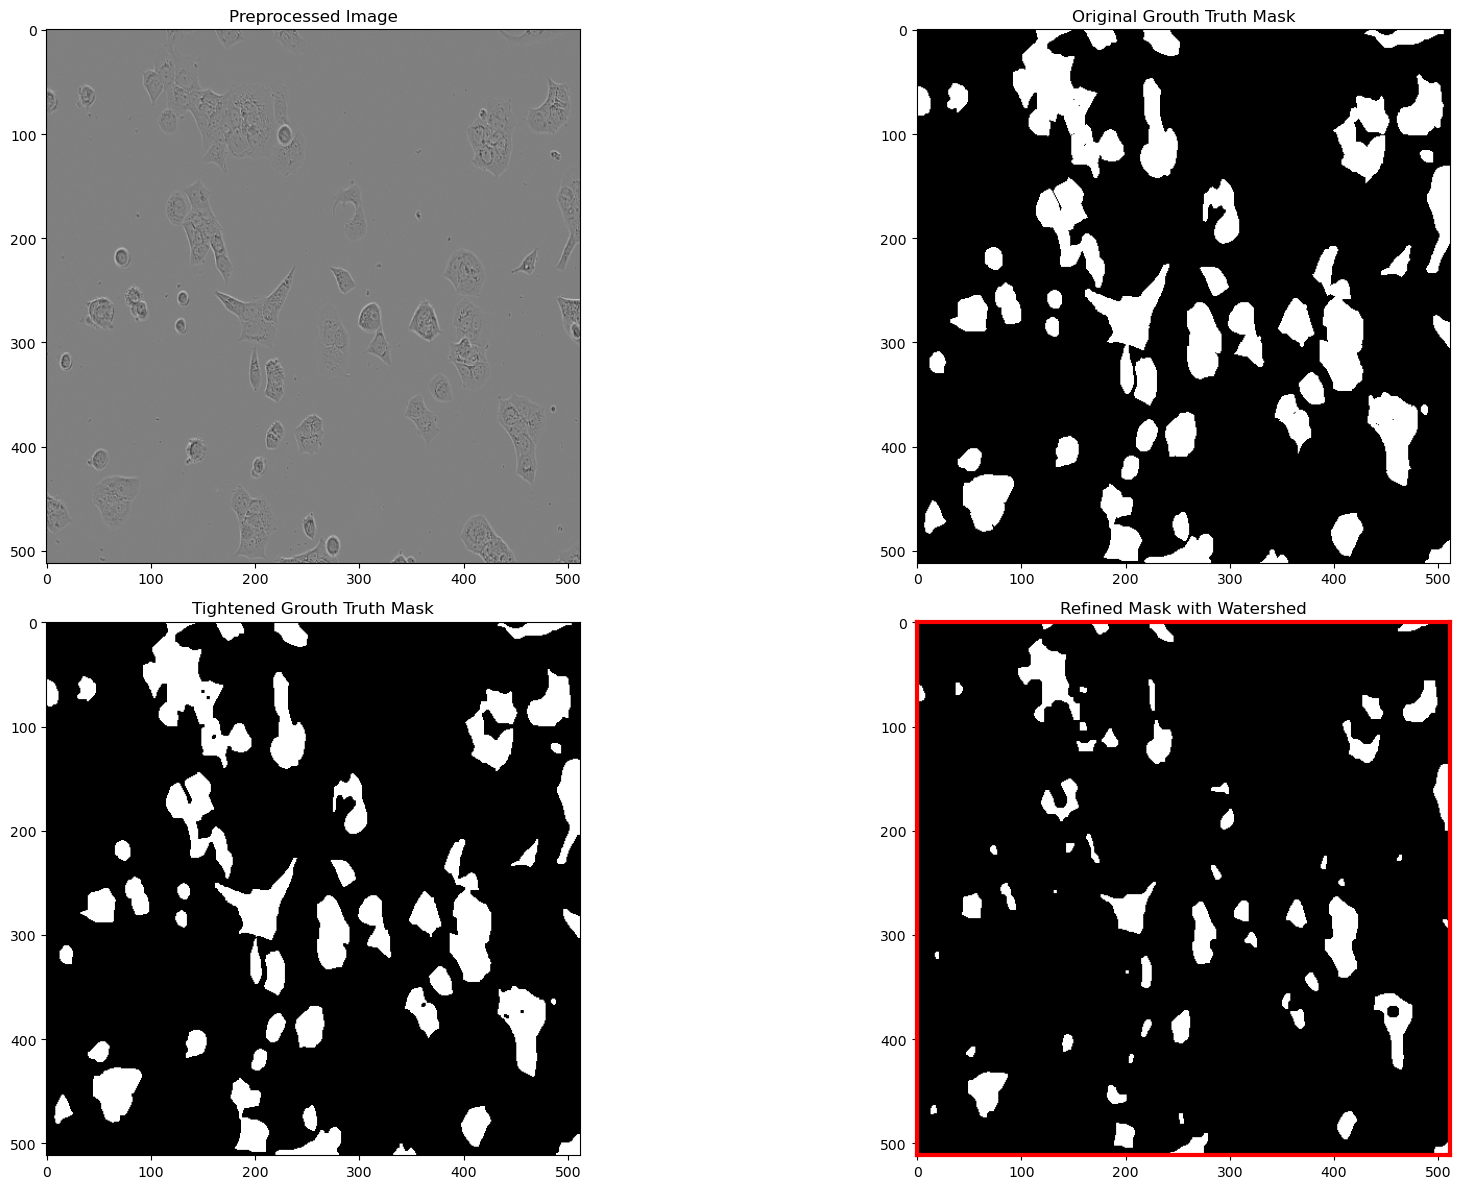

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to refine the mask using watershed
def split_cells_with_watershed(mask):
    """
    Refines a binary mask to split connected cell regions using the watershed algorithm.
    """
    # Step 1: Distance Transform
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)  # Lower threshold

    # Step 2: Dilate foreground markers slightly
    kernel = np.ones((3, 3), np.uint8)
    sure_fg = cv2.dilate(np.uint8(sure_fg), kernel, iterations=1)  # Expand markers

    # Step 3: Unknown regions
    unknown = cv2.subtract(mask, sure_fg)

    # Step 4: Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Step 5: Apply Watershed
    image_copy = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR)
    cv2.watershed(image_copy, markers)

    # Create refined mask
    refined_mask = np.zeros_like(mask)
    refined_mask[markers > 1] = 255

    return refined_mask

# Tighten the Grouth Truth mask using erosion and Gaussian smoothing
kernel = np.ones((3, 3), np.uint8)  # Define a small 3x3 kernel
mask_tightened = cv2.erode(mask, kernel, iterations=1)  # Apply erosion
mask_smoothed = cv2.GaussianBlur(mask_tightened.astype(np.float32), (3, 3), 0)  # Smooth edges
mask_final = (mask_smoothed > 0.5).astype(np.uint8)  # Re-binarise the mask

# Apply Watershed Segmentation to the tightened mask
mask_watershed = split_cells_with_watershed(mask_final)

# Visualise all results
plt.figure(figsize=(20, 12))

# Preprocessed Image
plt.subplot(2, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(image)

# Original Grouth Truth Mask
plt.subplot(2, 2, 2)
plt.title("Original Grouth Truth Mask")
plt.imshow(mask, cmap='gray')

# Tightened Grouth Truth Mask
plt.subplot(2, 2, 3)
plt.title("Tightened Grouth Truth Mask")
plt.imshow(mask_final, cmap='gray')

# Refined Mask with Watershed
ax = plt.subplot(2, 2, 4)
plt.title("Refined Mask with Watershed")
plt.imshow(mask_watershed, cmap='gray')

# Customise the spines to add a red border
for spine in ax.spines.values():
    spine.set_edgecolor('red')  # Set the color of the border to red
    spine.set_linewidth(3)      # Set the width of the border

plt.tight_layout()
plt.show()

**Summary**

**Tightened Ground Truth Mask**  
- The tightened ground truth mask appears cleaner, retains the overall cell structure, and aligns with the goal of prioritising confluence over cell count.

**Watershed Segmentation**  
- The watershed method tends to over-segment cells, making it more suitable for precise individual cell detection rather than confluence measurement.
- For the current objective, this method is not ideal.

**Decision**  
- Skip the watershed segmentation for now.  
- Use the tightened ground truth mask as the final mask for segmentation.  
- Semantic segmentation is sufficient for current needs.

**Justification**  
- **Focus on Confluence:** Prioritising overall cell area over individual boundaries aligns with the project's objectives.  
- **Thorough Exploration:** Including alternative methods, like watershed segmentation, demonstrates a systematic approach.  
- **Future Adaptability:** Documenting the exploration provides a reference if future requirements demand precise individual cell boundaries.

##  Preprocess Dataset with Tightened Ground Truth Mask and Prepare Data for Model Training

### Code to Loop Through All Images

What This Code Does:

- Iterates through all matched images in your phase_contrast folder.
- For each image:
    - Loads the image and corresponding annotations.
    - Preprocesses the image and mask to size (512, 512).
- Stores the preprocessed images and masks in two lists.
- Saves the data as NumPy arrays (images.npy and masks.npy) for efficient model training.

In [20]:
import numpy as np
import os
import cv2

# Directory to save preprocessed data
output_dir = r"C:\Users\shali\Documents\L&D\GitHub Projects\Machine Learning\003_LIVECell_Segmentation of Cells_U-Net\processed_data_unet"
os.makedirs(output_dir, exist_ok=True)

# Paths to save images and masks
images_output_path = os.path.join(output_dir, "images.npy")
masks_output_path = os.path.join(output_dir, "masks.npy")

# Initialise lists to store images and tightened masks
all_images = []
all_masks = []

# Function to tighten grouth truth mask
def tighten_binary_mask(mask):
    kernel = np.ones((3, 3), np.uint8)  # Small kernel for erosion
    mask_tightened = cv2.erode(mask, kernel, iterations=1)  # Erode mask
    mask_smoothed = cv2.GaussianBlur(mask_tightened.astype(np.float32), (3, 3), 0)  # Smooth edges
    mask_final = (mask_smoothed > 0.5).astype(np.uint8)  # Re-binarise
    return mask_final

# Process all matched images
for image_file, image_id in image_filename_to_id.items():
    # Load image and annotations
    image_path = os.path.join(image_folder, image_file)
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Preprocess image and original mask
    image, mask = preprocess_image_and_mask(image_path, annotations, img_size=(512, 512))
    
    # Tighten the binary mask
    mask_tightened = tighten_binary_mask(mask)
    
    # Append preprocessed image and tightened mask to lists
    all_images.append(image)
    all_masks.append(mask_tightened)

    # Print progress
    print(f"Processed: {image_file}")

# Convert lists to NumPy arrays
all_images = np.array(all_images, dtype=np.float32)
all_masks = np.array(all_masks, dtype=np.uint8)

# Save the arrays
np.save(images_output_path, all_images)
np.save(masks_output_path, all_masks)

print("Processing complete!")
print(f"Images saved to: {images_output_path}")
print(f"Masks saved to: {masks_output_path}")

Processed: BT474_Phase_A3_1_01d04h00m_1.tif
Processed: BT474_Phase_A3_1_03d00h00m_4.tif
Processed: BT474_Phase_A3_1_01d12h00m_1.tif
Processed: BT474_Phase_A3_1_04d16h00m_2.tif
Processed: BT474_Phase_A3_1_01d04h00m_4.tif
Processed: BT474_Phase_A3_1_00d04h00m_4.tif
Processed: BT474_Phase_A3_1_04d16h00m_3.tif
Processed: BT474_Phase_A3_1_00d04h00m_1.tif
Processed: BT474_Phase_A3_1_03d12h00m_4.tif
Processed: BT474_Phase_A3_1_03d04h00m_1.tif
Processed: BT474_Phase_A3_1_00d12h00m_2.tif
Processed: BT474_Phase_A3_1_02d16h00m_3.tif
Processed: BT474_Phase_A3_1_00d00h00m_2.tif
Processed: BT474_Phase_A3_1_01d04h00m_3.tif
Processed: BT474_Phase_A3_1_04d12h00m_1.tif
Processed: BT474_Phase_A3_1_00d00h00m_3.tif
Processed: BT474_Phase_A3_1_02d16h00m_1.tif
Processed: BT474_Phase_A3_1_01d00h00m_4.tif
Processed: BT474_Phase_A3_1_02d04h00m_1.tif
Processed: BT474_Phase_A3_1_04d04h00m_3.tif
Processed: BT474_Phase_A3_1_03d12h00m_1.tif
Processed: BT474_Phase_A3_1_04d00h00m_3.tif
Processed: BT474_Phase_A3_1_03d0

### Verify Saved Data

Loaded images shape: (572, 512, 512, 3)
Loaded masks shape: (572, 512, 512)


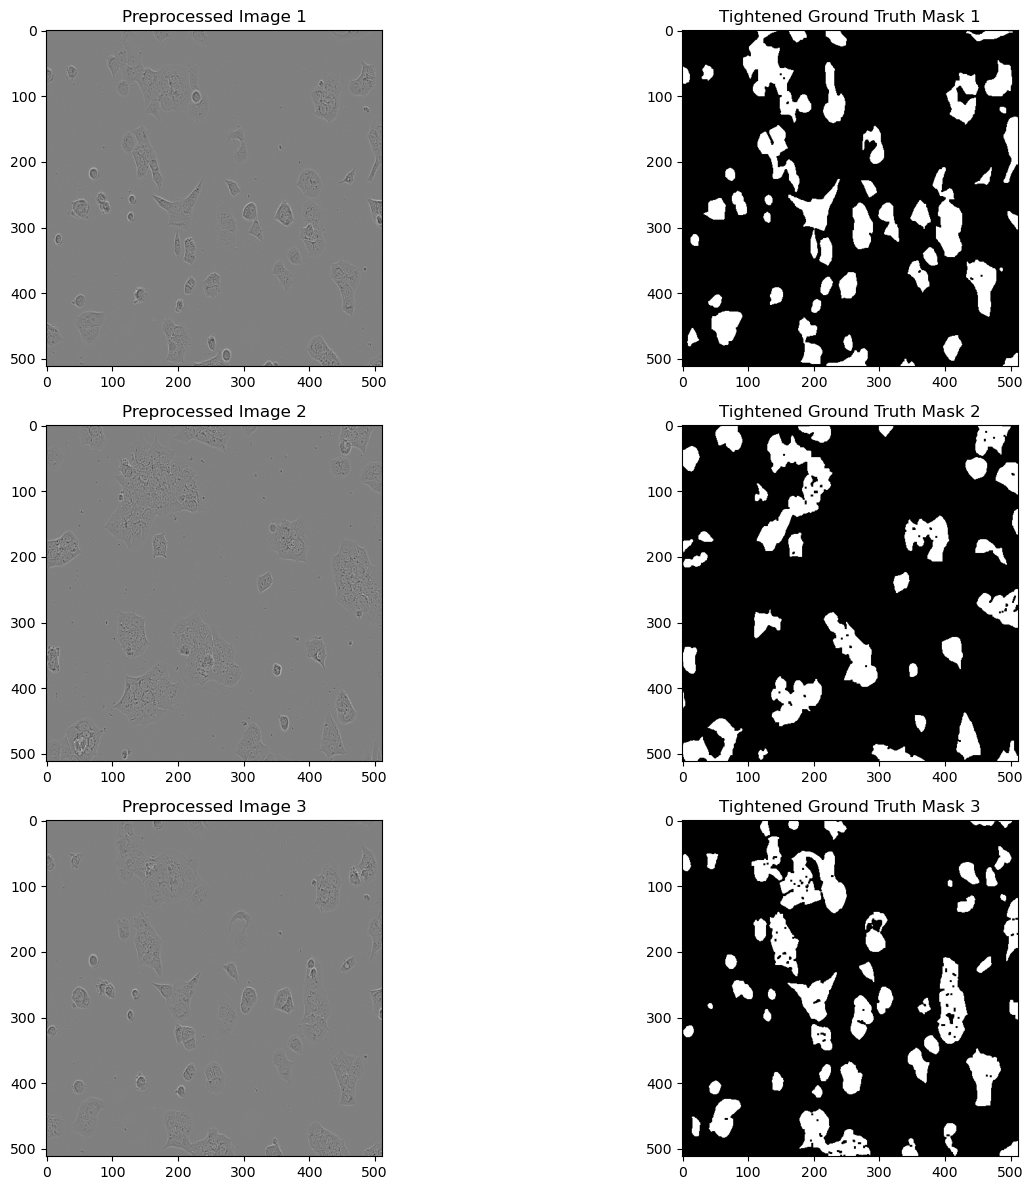

In [22]:
# Load the preprocessed data
images = np.load(images_output_path)
masks = np.load(masks_output_path)

print(f"Loaded images shape: {images.shape}")
print(f"Loaded masks shape: {masks.shape}")

# Visualise a few examples
num_examples = 3  # Number of images and masks to display

plt.figure(figsize=(15, 4 * num_examples))

for i in range(num_examples):
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.title(f"Preprocessed Image {i + 1}")
    plt.imshow(images[i])

    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.title(f"Tightened Ground Truth Mask {i + 1}")
    plt.imshow(masks[i], cmap='gray')

plt.tight_layout()
plt.show()

**Shape Consistency**  
- **Images:** Preprocessed images have consistent dimensions `(572, 512, 512, 3)` with aligned shapes and expected colour channels.  
- **Masks:** Masks are consistently shaped `(572, 512, 512)` with no channel redundancy, as they are grayscale.

**Visual Clarity**  
- Preprocessed images are clean and uniformly scaled.  
- Tightened binary masks are well-defined, with minimal noise and clear boundaries around the cells.

**Alignment**  
- Masks accurately overlay the regions corresponding to cell areas in the preprocessed images.  
- A clear distinction is maintained between cells (white) and background (black), ensuring accurate representation.

## Train a Segmentation Model

### Libraries for U-Net with Implementation

In [24]:
!pip install tensorflow

### Train-Validation Split and Ground Truth Mask Inspection

Split the preprocessed dataset (images and masks) into training and validation sets (80-20 split).

Training set: (457, 512, 512, 3), (457, 512, 512)
Validation set: (115, 512, 512, 3), (115, 512, 512)


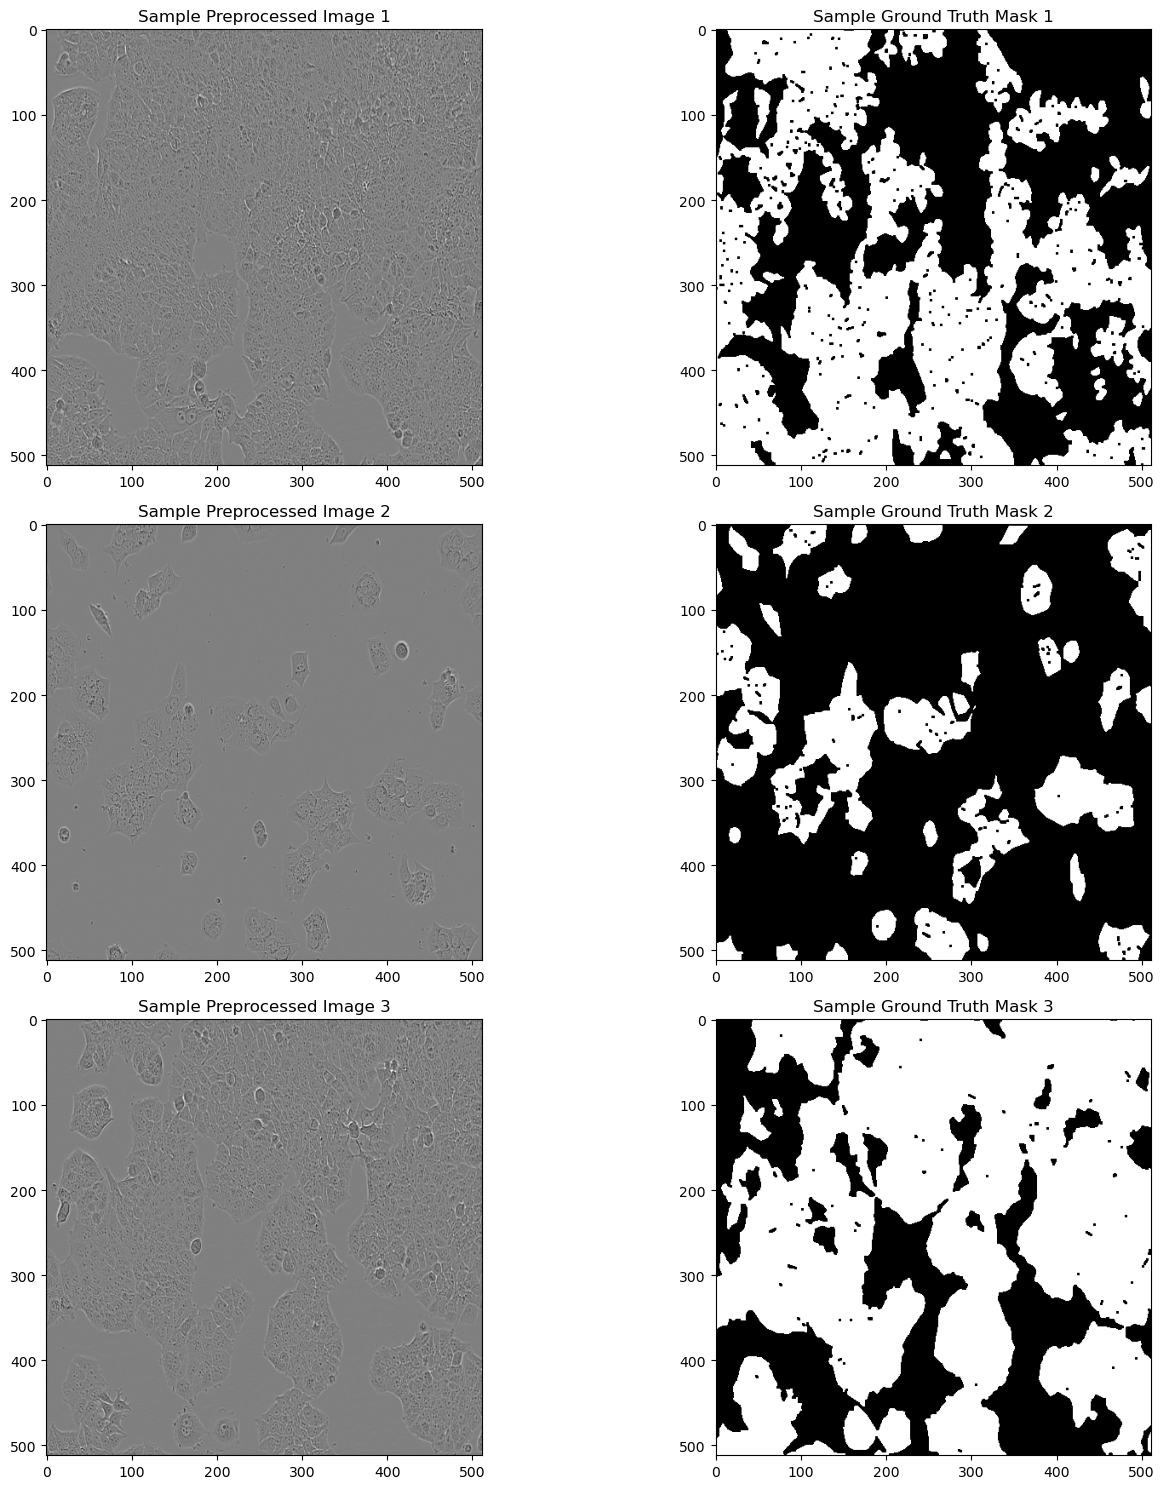

Ground Truth Mask Min/Max: 0 1


In [26]:
# Import libraries
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load preprocessed data
images = np.load(images_output_path)
masks = np.load(masks_output_path)

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# Number of images to visualise
num_examples = 3

plt.figure(figsize=(15, 5 * num_examples))

for i in range(num_examples):
    # Display the preprocessed image
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.title(f"Sample Preprocessed Image {i + 1}")
    plt.imshow(X_train[i])

    # Display the corresponding ground truth mask
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.title(f"Sample Ground Truth Mask {i + 1}")
    plt.imshow(y_train[i].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

# Check the min/max values of the first mask
print("Ground Truth Mask Min/Max:", y_train[0].min(), y_train[0].max())

## Debug Data → Confirm alignment, scaling, and mask quality.

Check the alignment and quality of your images and masks to confirm that preprocessing is correct.

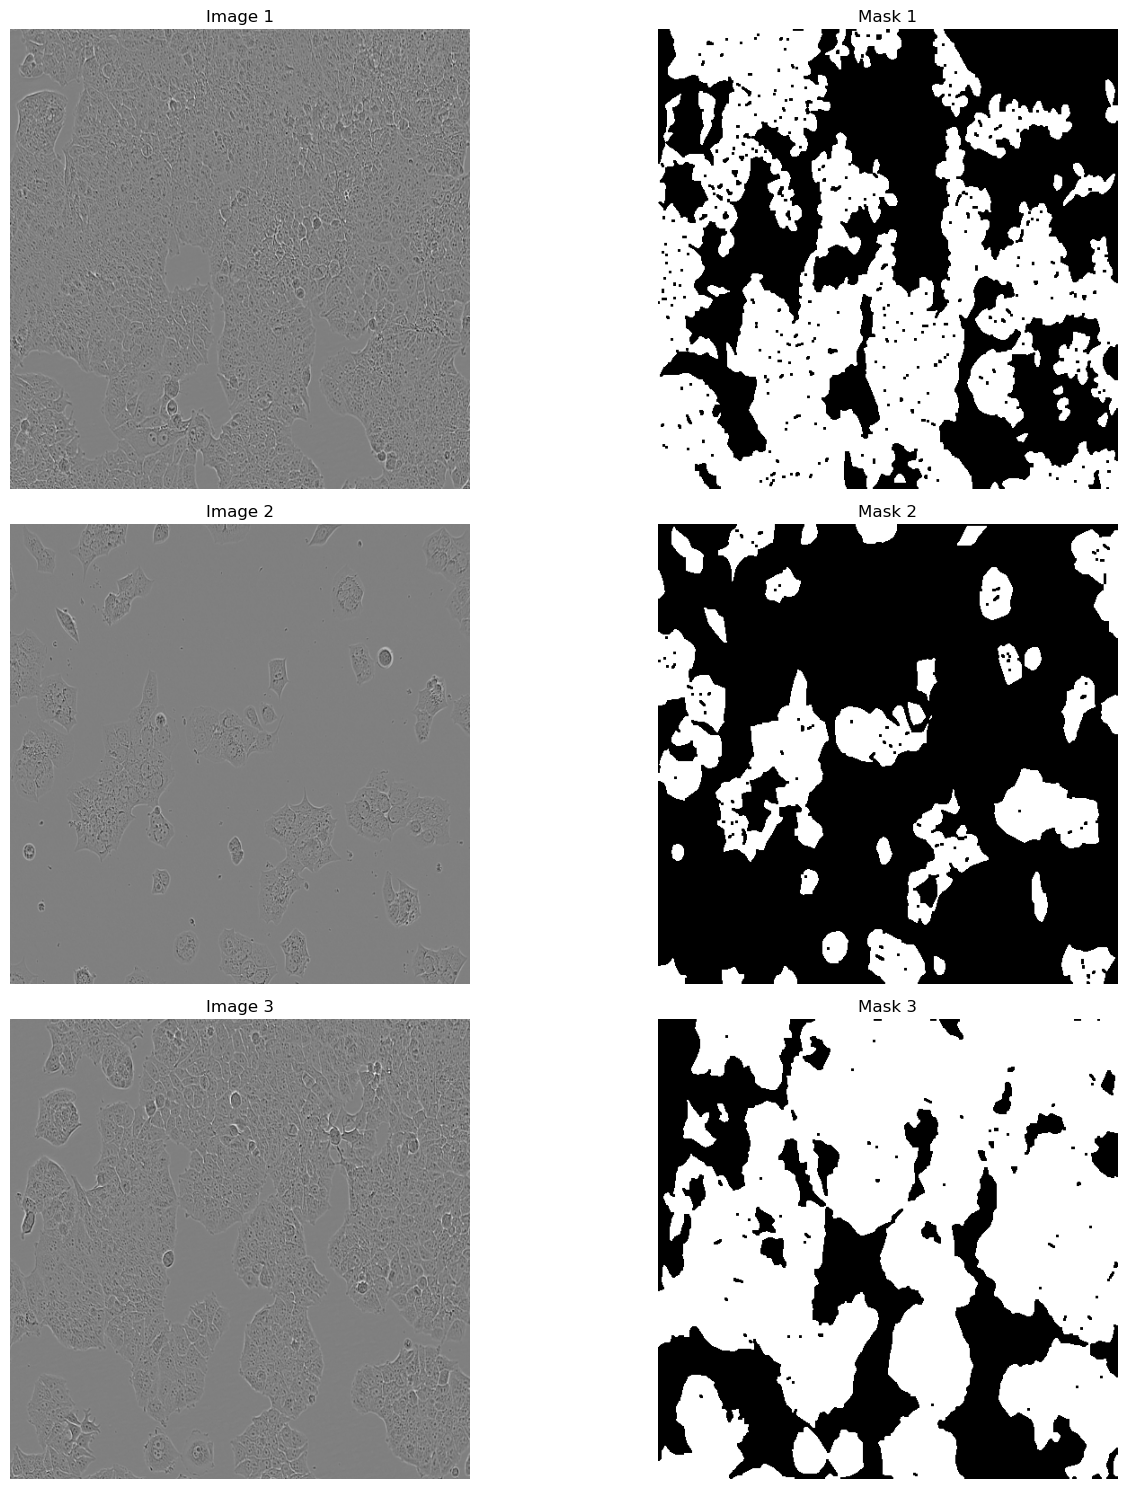

In [28]:
import matplotlib.pyplot as plt

def visualise_images_and_masks(images, masks, num_samples=5):
    """
    Visualise image-mask pairs to confirm alignment, scaling, and mask quality.

    Args:
        images (numpy.ndarray): Array of preprocessed images.
        masks (numpy.ndarray): Array of binary masks.
        num_samples (int): Number of samples to visualise.
    """
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Display the preprocessed image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i+1}")
        plt.axis("off")

        # Display the corresponding mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualise the first 5 samples from the training set
visualise_images_and_masks(X_train, y_train, num_samples=3)

In [30]:
print("Unique values in masks:", np.unique(y_train))

Unique values in masks: [0 1]


**Images and Masks**  
- The masks align visually with the corresponding preprocessed images.  
- They exhibit clean, well-defined boundaries.

**Unique Values in Masks**  
- `[0, 1]` confirms the masks are binary, as expected.  
- This is essential for training a segmentation model effectively.

## Build U-Net Model 

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Simplified U-Net Architecture
def unet(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling path)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)

    # Decoder (Upsampling path)
    u3 = layers.UpSampling2D((2, 2))(bottleneck)
    u3 = layers.Concatenate()([u3, c3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.UpSampling2D((2, 2))(u3)
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.UpSampling2D((2, 2))(u2)
    u1 = layers.Concatenate()([u1, c1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u1)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
unet_model = unet(input_shape=(512, 512, 3))
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 512, 512, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 256, 256, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 64, 64, 128)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 128, 128, 256)     │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 384)     │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 128)     │         442,496 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 256, 256, 128)     │               0 │ conv2d_4[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 256, 256, 192)     │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 256, 256, 64)      │         110,656 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_2               │ (None, 512, 512, 64)      │               

 Total params: 969,281 (3.70 MB)

 Trainable params: 969,281 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

### Baseline Model Check → Input, Ground Truth, and Initial Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step


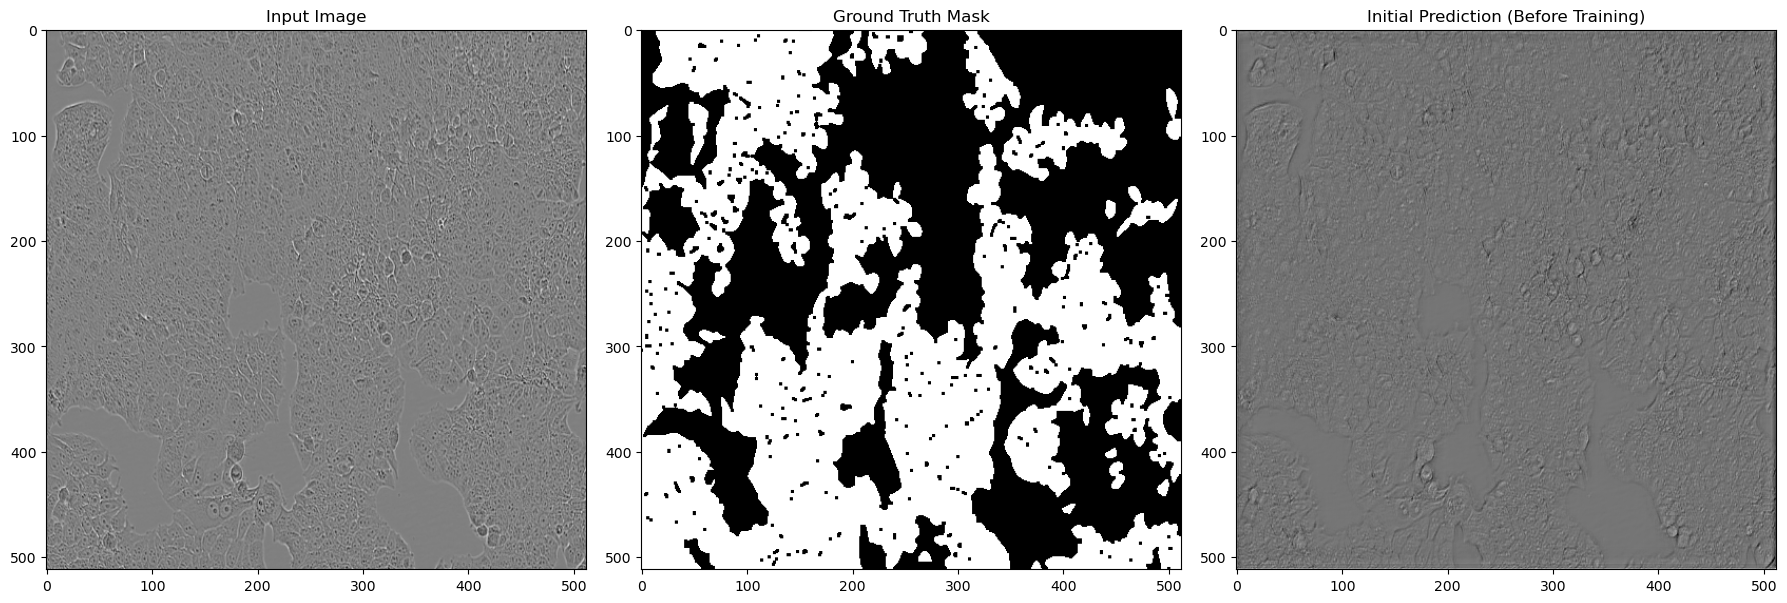

Initial Prediction Min/Max: 0.4516422 0.5061056
Prediction Shape: (1, 512, 512, 1)


In [34]:
# Instantiate the U-Net model
model = unet(input_shape=(512, 512, 3))  # Simplified U-Net function

# Make initial predictions on a batch of training images
sample_input = X_train[:1]  # Take one image from the training set
sample_mask = y_train[:1]   # Corresponding ground truth mask

# Ensure sample_mask has the correct shape
if len(sample_mask.shape) == 3:  # If missing channel dimension
    sample_mask = np.expand_dims(sample_mask, axis=-1)  # Shape: (1, 512, 512, 1)

sample_preds = model.predict(sample_input)

# Clip predictions to range [0, 1] for visualisation
sample_preds = np.clip(sample_preds, 0, 1)

# Visualise Input, Ground Truth, and Initial Prediction
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(sample_input[0])

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(sample_mask[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Initial Prediction (Before Training)")
plt.imshow(sample_preds[0].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

# Print Prediction Stats
print("Initial Prediction Min/Max:", sample_preds.min(), sample_preds.max())
print("Prediction Shape:", sample_preds.shape)

**Pre-Training**  
- Ensures the model is functioning correctly, with predictions falling within the expected range `[0, 1]`.

**Post-Training**  
- Min/Max values provide insights into the model's confidence in classifying regions as foreground or background.  
- Values clustered around `0.5` may indicate insufficient training or potential data issues.

In [36]:
# Check for mismatched dimensions in masks
print("Checking dimensions of masks...")
if len(masks.shape) == 3:  # Add channel dimension if missing
    print("Adding channel dimension to masks...")
    masks = np.expand_dims(masks, axis=-1)
print(f"Updated masks shape: {masks.shape}")

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

Checking dimensions of masks...
Adding channel dimension to masks...
Updated masks shape: (572, 512, 512, 1)
Training data shape: (457, 512, 512, 3), Training masks shape: (457, 512, 512, 1)
Validation data shape: (115, 512, 512, 3), Validation masks shape: (115, 512, 512, 1)


In [38]:
print(f"Training set size: {len(X_train)}")
batch_size = 16
steps_per_epoch = len(X_train) // batch_size
print(f"Calculated steps per epoch: {steps_per_epoch}")

Training set size: 457
Calculated steps per epoch: 28


## Compile and Train the Model

will use the following:

- Binary Cross-Entropy as the loss function.
- IoU (Intersection over Union) as a metric.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define IoU (Intersection over Union) and Dice Coefficient
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions at 0.5
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())  # Add epsilon to avoid division by zero

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions at 0.5
    intersection = K.sum(y_true * y_pred)
    dice = (2. * intersection) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
    return dice

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Match learning rate with .py script
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric, dice_coefficient]
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Train the model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,  
    callbacks=[early_stopping, reduce_lr],  # Include callbacks
    verbose=1  # Display progress bar
)

**Summary**

- **Custom Metrics:**  
  - The Intersection over Union (IoU) and Dice Coefficient are defined as additional metrics to evaluate the model's segmentation performance. These metrics focus on overlap between predictions and ground truth, ensuring accurate evaluation of segmentation quality.  

- **Model Compilation:**  
  - The model is compiled with the Adam optimiser (learning rate: `1e-4`), binary crossentropy loss, and evaluation metrics including accuracy, IoU, and Dice Coefficient.  

- **Callbacks:**  
  - EarlyStopping monitors `val_loss` and stops training after 5 epochs of no improvement, restoring the best weights.  
  - ReduceLROnPlateau reduces the learning rate by a factor of 0.5 if `val_loss` does not improve for 3 consecutive epochs, ensuring more stable training.

- **Training:**  
  - The model will be trained for 20 epochs with a batch size of 16, using the defined callbacks for improved training efficiency.  
  - Training is performed with `X_train` and `y_train`, and validation is done using `X_val` and `y_val`.

**Note:**  
The model will be trained on the Anaconda prompt, **not within this notebook**, to avoid potential resource limitations and ensure smooth execution.